In [1]:
from __future__ import division, absolute_import

import numpy as np

from bcn.bias import guess_func
from bcn.data import DataSimulated, estimate_partial_signal_characterists
from bcn.cost import Cost
from bcn.solvers import ConjugateGradientSolver
from bcn.linear_operators import LinearOperatorCustom, possible_measurements

import pylab as pl

In [2]:
np.random.seed(seed=42)

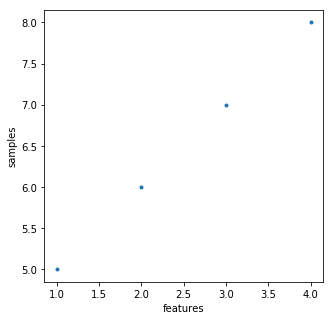

In [3]:
fig = pl.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.plot([1,2,3,4], [5, 6, 7, 8], '.')
ax.set_xlabel('features')
ax.set_ylabel('samples')
fig.savefig('test')

In [22]:
# Setup of general parameters for the recovery experiment.
sparsity = 2
n_restarts = 10
rank = 6
n_measurements = 10000
shape = (100, 110) # samples, features
missing_fraction = 0.1
noise_amplitude = 30.0
m_blocks_size = 50 # size of each block
correlation_threshold = 0.9
bias_model = 'image'

In [23]:
# Number of possible measurements (more equals better signal recovery) 
possible_measurements(shape, missing_fraction, m_blocks_size=m_blocks_size)

{'m_blocks=2/2 (actual case)': 'TODO',
 'm_blocks=2/2 (worst case)': 509850,
 'm_blocks=50/55 (best case)': 9900}

In [24]:
# Creation of the corrupted signal.
truth = DataSimulated(shape, rank, bias_model=bias_model, correlation_threshold=correlation_threshold, m_blocks_size=m_blocks_size, noise_amplitude=noise_amplitude, missing_fraction=missing_fraction)
mixed = truth.d['sample']['mixed']

In [25]:
true_pairs = {'sample': truth.d['sample']['true_pairs'], 'feature': truth.d['feature']['true_pairs']}
true_directions = {'sample': truth.d['sample']['true_directions'], 'feature': truth.d['feature']['true_directions']}
true_stds = {'sample': truth.d['sample']['true_stds'], 'feature': truth.d['feature']['true_stds']}

In [26]:
signal_characterists = estimate_partial_signal_characterists(mixed, correlation_threshold, true_pairs=true_pairs, true_directions=true_directions, true_stds=true_stds)

In [27]:
# Construct measurements from corrupted signal and its estimated partial characteristics.
operator = LinearOperatorCustom(n_measurements)
measurements = operator.generate(signal_characterists)

In [28]:
# Construct cost function.
cost = Cost(measurements['A'], measurements['y'], sparsity)

In [29]:
# Recover the bias.
solver = ConjugateGradientSolver(mixed, cost.cost_func, guess_func, rank, n_restarts, verbosity=0)
results = solver.recover()

In [30]:
# Recovery performance statistics.
error_cost_func_true_bias = cost.cost_func(truth.d['sample']['true_bias'])
error_cost_func_estimated_bias = cost.cost_func(results['estimated_bias'])
print 'error_cost_func_true_bias', error_cost_func_true_bias
print 'error_cost_func_estimated_bias', error_cost_func_estimated_bias

divisor = np.sum(~np.isnan(mixed))
print 'number of valid values', divisor

mean_absolute_error_true_signal = np.nansum(np.absolute(truth.d['sample']['signal'] - (mixed - truth.d['sample']['true_bias']))) / divisor
mean_absolute_error_estimated_signal = np.nansum(np.absolute(truth.d['sample']['signal'] - results['estimated_signal'])) / divisor
print 'mean_absolute_error_true_signal', mean_absolute_error_true_signal
print 'mean_absolute_error_estimated_signal', mean_absolute_error_estimated_signal

mean_absolute_error_zeros = np.nansum(np.absolute(truth.d['sample']['signal'] - mixed)) / divisor
print 'mean_absolute_error_zeros', mean_absolute_error_zeros

ratio_estimated_signal_to_zeros = mean_absolute_error_estimated_signal / mean_absolute_error_zeros
print 'ratio_estimated_signal_to_zeros', ratio_estimated_signal_to_zeros
    

error_cost_func_true_bias 2.903330946458054e-14
error_cost_func_estimated_bias 1.5002761437752586e-14
number of valid values 9900
mean_absolute_error_true_signal 1.1902699995658742e-17
mean_absolute_error_estimated_signal 6.798776909820044e-08
mean_absolute_error_zeros 0.187283140416693
ratio_estimated_signal_to_zeros 3.6302129997890897e-07
